In [1]:
from fastai.text import *
from fastai.lm_rnn import *
import sentencepiece as sp
from scipy import stats
import fastai.core

In [2]:
fastai.core.USE_GPU = True

In [3]:
torch.cuda.set_device(2)

In [4]:
BTW17 = Path("../data/btw17")
GE17  = Path("../data/germeval2017")
WORK = Path("../work/")
WIKI=Path("../data/wiki/de")
!ls {WORK}
!ls {GE2017}/
!ls {WIKI}

btw-nouniq30k  ge2017  shared  shared-wiki  wiki30k
ls: cannot access '{GE2017}/': No such file or directory
train.csv  train.txt  val.csv


In [5]:
GE17WRK = WORK/"ge2017/tmp"
GE17ML = WORK/"ge2017/models"
!ls {GE17WRK}

dev_ids.npy    lbl_test2.npy  sp.model	     trn_ids_all.npy
lbl_dev.npy    lbl_trn.npy    test1_ids.npy  trn_ids.npy
lbl_test1.npy  lbl_val.npy    test2_ids.npy  val_ids.npy


In [6]:
trn_lbl = np.load(GE17WRK/'lbl_trn.npy')

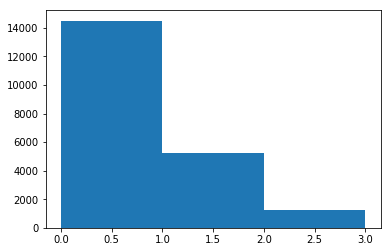

In [7]:
from matplotlib import pyplot
pyplot.hist(trn_lbl, bins=[0,1,2,3])
pyplot.show()

In [8]:
np.histogram(trn_lbl)

(array([14497,     0,     0,     0,     0,  5228,     0,     0,     0,  1216]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]))

In [46]:
1216/sum([14497,     0,     0,     0,     0,  5228,     0,     0,     0,  1216])

0.05806790506661573

# Prediction

In [9]:
!ls {GE17ML}

fwd_class2-nl-4-ge2017_clas_0.h5  fwd_class-nodisc-nl-4-ge2017_clas_0.h5
fwd_class2-nl-4-ge2017_clas_1.h5  fwd_class-nodisc-nl-4-ge2017_clas_1.h5
fwd_class3-nl-4-ge2017_clas_0.h5  fwd_nl-4-ge2017-all_lm_enc.h5
fwd_class3-nl-4-ge2017_clas_1.h5  fwd_nl-4-ge2017-all_lm.h5
fwd_class4-nl-4-ge2017_clas_0.h5  fwd_nl-4-ge2017_lm_enc.h5
fwd_class4-nl-4-ge2017_clas_1.h5  fwd_nl-4-ge2017_lm.h5
fwd_class-nl-4-ge2017_clas_0.h5


In [10]:
test_file='test1'

In [11]:
tst = np.load(GE17WRK/f"{test_file}_ids.npy")
lbl = np.load(GE17WRK/f"lbl_{test_file}.npy")

In [12]:
stats.describe(lbl)

DescribeResult(nobs=2566, minmax=(0, 2), mean=0.3858144972720187, variance=0.3189253987137237, skewness=1.138364186781599, kurtosis=0.30183641408565753)

In [13]:
spp = sp.SentencePieceProcessor()
spp.Load(str(GE17WRK / 'sp.model'))
vs = spp.GetPieceSize()  # len(itos)
spp.SetEncodeExtraOptions("bos:eos")

True

In [14]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])
bptt,em_sz,nh,nl = 70,400,1150,4
c=3
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])
load_model(m, GE17ML/"fwd_class4-nl-4-ge2017_clas_1.h5")


In [15]:
m=to_gpu(m)
m.reset()
m.eval()

SequentialRNN(
  (0): MultiBatchRNN(
    (encoder): Embedding(30000, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(30000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 1150)
      )
      (3): WeightDrop(
        (module): LSTM(1150, 400)
      )
    )
    (dropouti): LockedDropout()
    (dropouths): ModuleList(
      (0): LockedDropout()
      (1): LockedDropout()
      (2): LockedDropout()
      (3): LockedDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): ModuleList(
      (0): LinearBlock(
        (lin): Linear(in_features=1200, out_features=50, bias=True)
        (drop): Dropout(p=0.4)
        (bn): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): LinearBlock(
        (lin): Linear(in_fe

In [16]:
tst.shape

(2566,)

In [17]:
batch = tst[1][:,None]
print(batch.shape)
res, *_ = m(T(batch))
F.softmax(res)

(63, 1)


tensor([[0.9991, 0.0007, 0.0002]], device='cuda:2', grad_fn=<SoftmaxBackward>)

In [31]:
bs=120
tst_ds = TextDataset(tst, lbl)
tst_samp = SortSampler(tst, key=lambda x: len(tst[x]))
tst_dl = DataLoader(tst_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=tst_samp)

In [32]:
res = predict_with_targs(m, tst_dl)
res

(array([[ 2.43034, -0.26553, -5.47346],
        [ 2.53927, -1.87702, -3.83591],
        [ 5.69727, -2.52038, -8.09855],
        ...,
        [ 6.51441, -4.54143, -5.47961],
        [ 6.51441, -4.54143, -5.47961],
        [ 6.51441, -4.54143, -5.47961]], dtype=float32),
 array([0, 0, 0, ..., 0, 0, 0]))

In [33]:
res[0].shape

(2566, 3)

In [34]:
preds = np.argmax(res[0], axis=1)
preds

array([0, 0, 0, ..., 0, 0, 0])

In [35]:
true_y=res[1]

In [36]:
from sklearn.metrics import confusion_matrix
from fastai.plots import plot_confusion_matrix

[[1513  143   25]
 [ 345  416   19]
 [  72   13   20]]


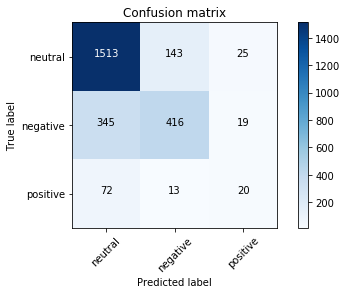

In [37]:
cm = confusion_matrix(true_y, preds)
plot_confusion_matrix(cm, ['neutral', 'negative', 'positive'])

In [38]:
from sklearn.metrics import f1_score
f1_score(true_y, preds, average='micro')

0.7595479345284488

In [39]:
f1_score(true_y, true_y, average='micro')

1.0

In [40]:
len(true_y)

2566

In [41]:
split=600
f1_score(true_y, np.concatenate([true_y[:split],preds[split:]]), average='micro')

0.8164458300857366

[[1559  103   19]
 [ 270  495   15]
 [  54   10   41]]


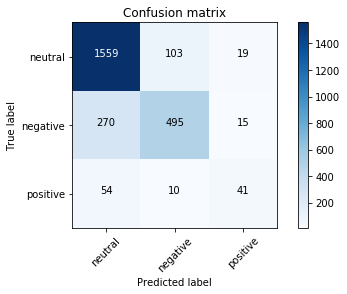

In [42]:
cm = confusion_matrix(true_y, np.concatenate([true_y[:split],preds[split:]]))
plot_confusion_matrix(cm, ['neutral', 'negative', 'positive'])